In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def fetch_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    data['Return'] = data['Adj Close'].pct_change()
    return data

In [27]:
def calculate_indicators(data, short_window=40, long_window=100, rsi_period=14, macd_fast=12, macd_slow=26, macd_signal=9):
    # Moving Averages
    data['Short_MA'] = data['Adj Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Adj Close'].rolling(window=long_window, min_periods=1).mean()
    
    # RSI
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    data['MACD'] = data['Adj Close'].ewm(span=macd_fast, adjust=False).mean() - data['Adj Close'].ewm(span=macd_slow, adjust=False).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=macd_signal, adjust=False).mean()
    
    # Bollinger Bands
    data['Middle_Band'] = data['Adj Close'].rolling(window=20).mean()
    data['Upper_Band'] = data['Middle_Band'] + (data['Adj Close'].rolling(window=20).std() * 2)
    data['Lower_Band'] = data['Middle_Band'] - (data['Adj Close'].rolling(window=20).std() * 2)
    
    return data

In [28]:
def combined_strategy(data):
    data['Signal'] = 0
    data['Signal'] = np.where(
        (data['Short_MA'] > data['Long_MA']) &
        (data['RSI'] < 70) &
        (data['MACD'] > data['Signal_Line']) &
        (data['Adj Close'] < data['Upper_Band']) &
        (data['Adj Close'] > data['Middle_Band']),  # Additional filter to ensure price is above the middle band
        1, 0
    )
    data['Position'] = data['Signal'].diff()
    return data

In [29]:
def backtest_strategy(data, initial_capital=1000000):
    capital_per_trade = initial_capital / 10  # Allocating 10% of capital per trade
    data['Position_Size'] = capital_per_trade // data['Adj Close']
    data['Holdings'] = data['Position_Size'] * data['Adj Close'] * data['Position'].shift()
    data['Cash'] = initial_capital - (data['Adj Close'] * data['Position_Size'] * data['Position']).cumsum()
    data['Total'] = data['Holdings'] + data['Cash']
    data['Returns'] = data['Total'].pct_change()
    data['Profit'] = data['Total'] - initial_capital
    return data

In [30]:
def analyze_performance(data):
    trades = data[data['Position'] != 0]
    num_trades = len(trades) // 2  # Buy/Sell pairs
    winning_trades = trades[trades['Returns'] > 0]
    losing_trades = trades[trades['Returns'] <= 0]
    
    avg_return_per_trade = trades['Returns'].mean()
    avg_winning_return = winning_trades['Returns'].mean()
    avg_losing_return = losing_trades['Returns'].mean()
    win_loss_ratio = avg_winning_return / abs(avg_losing_return) if avg_losing_return != 0 else float('inf')
    win_rate = len(winning_trades) / num_trades if num_trades != 0 else 0
    
    return {
        'num_trades': num_trades,
        'avg_return_per_trade': avg_return_per_trade,
        'avg_winning_return': avg_winning_return,
        'avg_losing_return': avg_losing_return,
        'win_loss_ratio': win_loss_ratio,
        'win_rate': win_rate,
        'total_profit': data['Profit'].iloc[-1]
    }

In [31]:

def plot_results(data, ticker):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Price and moving averages
    ax1.plot(data.index, data['Adj Close'], label='Price', color='black')
    ax1.plot(data.index, data['Short_MA'], label='Short MA', color='blue')
    ax1.plot(data.index, data['Long_MA'], label='Long MA', color='red')
    ax1.fill_between(data.index, data['Upper_Band'], data['Lower_Band'], color='gray', alpha=0.2, label='Bollinger Bands')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    
    # Portfolio value
    ax2.plot(data.index, data['Total'], label='Portfolio Value', color='green')
    ax2.set_ylabel('Portfolio Value')
    ax2.legend(loc='upper left')
    
    plt.title(f'{ticker} Combined Strategy Backtest')
    plt.show()

[*********************100%%**********************]  1 of 1 completed

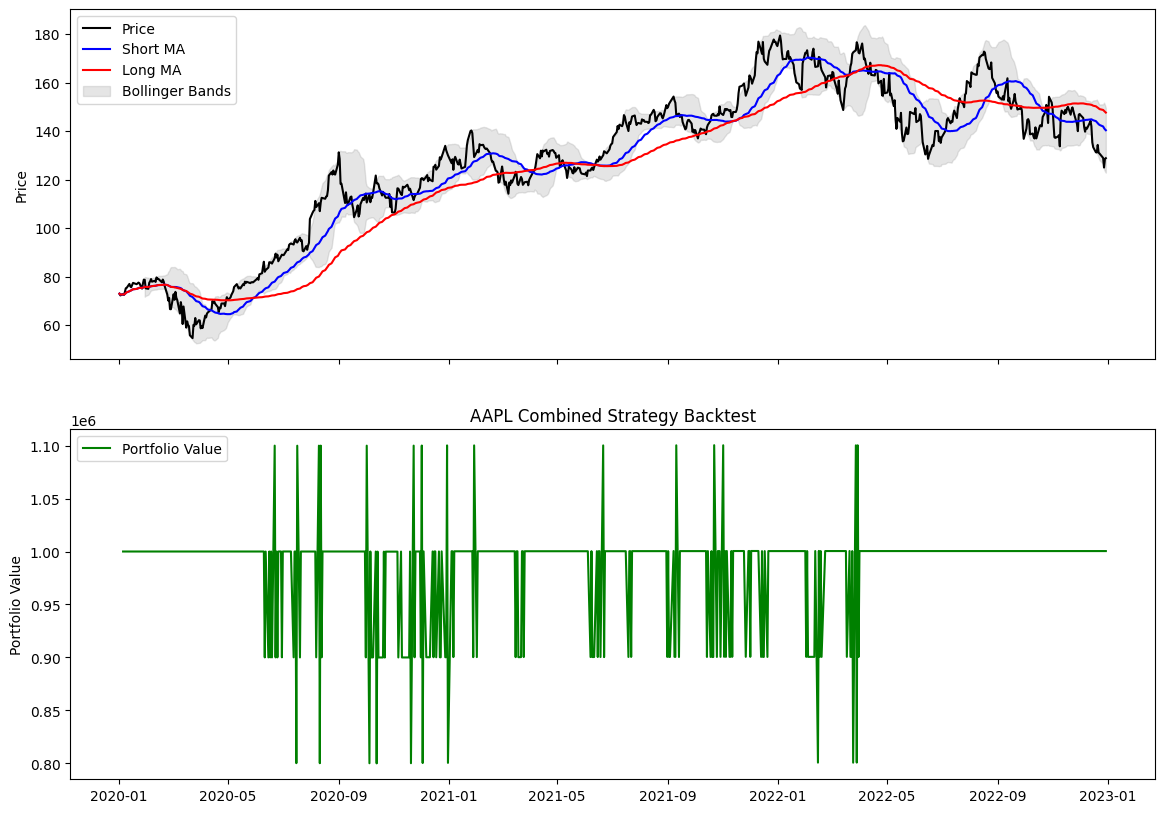

Number of trades: 36
Average return per trade: 0.0151
Average return for winning trades: 0.1526
Average return for losing trades: -0.1303
Win/Loss ratio: 1.1716
Win rate: 102.78%
Total profit: ₹413.34


In [32]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'

data = fetch_data(ticker, start_date, end_date)
data = calculate_indicators(data)
data = combined_strategy(data)
data = backtest_strategy(data, initial_capital=1000000)

performance = analyze_performance(data)
plot_results(data, ticker)

print(f"Number of trades: {performance['num_trades']}")
print(f"Average return per trade: {performance['avg_return_per_trade']:.4f}")
print(f"Average return for winning trades: {performance['avg_winning_return']:.4f}")
print(f"Average return for losing trades: {performance['avg_losing_return']:.4f}")
print(f"Win/Loss ratio: {performance['win_loss_ratio']:.4f}")
print(f"Win rate: {performance['win_rate']:.2%}")
print(f"Total profit: ₹{performance['total_profit']:.2f}")